In [1]:
from sklearn.cluster import KMeans, AffinityPropagation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.cluster.hierarchy as hcluster

import random

In [28]:
%matplotlib widget

In [26]:
# Lukas Directory
#batch1 = pd.read_parquet(r"C:\Users\schei\OneDrive\Desktop\icecube project\batch_1.parquet\batch_1.parquet")
#sensor_geom = pd.read_csv(r"C:\Users\schei\OneDrive\Dokumente\GitHub\ice-cube\sensor_geometry.csv")

#Ben Directory
batch1 = pd.read_parquet('/opt/app/data/erdos-data/train/batch_1.parquet')
sensor_geom = pd.read_csv('/opt/app/data/erdos-data/sensor_geometry.csv')
meta = pd.read_parquet('/opt/app/data/erdos-data/train_meta.parquet')

In [4]:
len(batch1[batch1.auxiliary==False].index)

23551893

In [15]:
def id_to_xyz(sen_id):
    return sensor_geom.loc[sen_id][['x','y','z']].values

In [ ]:
def normalize_charge(event):
    event_test=event.copy()
    column='charge'
    event_test['charge'] = (event['charge'] - event[column].min()) / (event[column].max() - event[column].min())
    return event_test

In [ ]:
def normalize_time(event):
    event_test=event.copy()
    event_test['time']=event['time']-(event['time'].min())
    return event_test

In [8]:
len(event_list)

23551893

In [7]:
batch1_small=batch1[batch1.auxiliary==False]
event_list=list(batch1_small.index)
len(event_list)

23551893

In [6]:
norm_batch=[]
i=0
for event_id in event_list:
    i+=1
    event=batch1.loc[event_id]
    norm_event=event.copy()
    norm_event=normalize_charge(norm_event)
    norm_event=normalize_time(norm_event)
    norm_batch.append(event)

NameError: name 'event_list' is not defined

In [9]:
batch1.keys()

Index(['sensor_id', 'time', 'charge', 'auxiliary'], dtype='object')

In [10]:
for i in range(0, len(event)):
    test.loc[i,['x','y','z']] = id_to_xyz(test.loc[i,'sensor_id'])

NameError: name 'event' is not defined

In [11]:
def mydist(a,b):
    diff=a-b
    return np.dot(diff*diff, (np.array([1,1,1,1])) )


In [39]:
def hcluster_euc_distance(event, threshhold=150):
    trunc_event=event[['sensor_id', 'charge']]
    raw_data = [id_to_xyz(trunc_event.iloc[i][0]) for i in range(len(trunc_event))]
    clusters = hcluster.fclusterdata(raw_data, threshhold, criterion='distance')
    return clusters, raw_data

In [13]:
def aff_cluster(event, seed, pref):
    trunc_event=event[['sensor_id', 'time', 'charge']]
    raw_data = [id_to_xyz(trunc_event.iloc[i][0] for i in range(len(trunc_event))]
    #raw_data= [event.iloc[i][1] for i in range(len(trunc_event))].reshape(-1,1)
    clusters= AffinityPropagation(random_state=seed, preference=pref, max_iter=100000).fit(raw_data)
    return clusters, raw_data

In [24]:
def event_plot(event_id, 
               aux_incl=False, 
               show_sensors=True,
               show_true_direction=False):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    event = batch1.loc[event_id]
    scale = 600
    
    # Aux false or both?
    if aux_incl==False:
        event = event[event.auxiliary==False]
    else:
        pass
    
    # Each sensor will register one point; total charge (sum over all 
    # times that sensor registered a charge) corresponds to size in plot
    sensors_and_charge = event.groupby('sensor_id').sum()['charge']
    sensors = np.array(sensors_and_charge.index)
    
    # Cartesian coords of sensors to plot
    xs = [id_to_xyz(s)[0] for s in sensors]
    ys = [id_to_xyz(s)[1] for s in sensors]
    zs = [id_to_xyz(s)[2] for s in sensors]
    
    # Sizes computed from values in sensors_and_charge 
    sizes = sensors_and_charge.values
    
    # Times are computed by first time sensor registered a pulse
    times = [event[event.sensor_id==s].time.values[0] for s in sensors]

    # This scatter plots the sensor pulses
    im = ax.scatter(xs, ys, zs,
                    c=times,
                    cmap='rainbow_r',
                    s=10*sizes,
                    zorder=2,
                    label='pulse',
                    alpha=1)
    
    # This plots the sensors
    if show_sensors==True:
        ax.scatter(sensor_geom.x, sensor_geom.y, sensor_geom.z,
                   c='0.1',
                   alpha=0.03,
                   s=0.5,
                   zorder=1)
        
    # This plots the true direction
    if show_true_direction==True:
        try: 
            df = meta[meta.event_id==event_id]
            az = df.azimuth.iloc[0]
            ze = df.zenith.iloc[0]
            xhat = np.cos(az)*np.sin(ze)
            yhat = np.sin(az)*np.sin(ze)
            zhat = np.cos(ze)
            
            xdir = scale*xhat
            ydir = scale*yhat
            zdir = scale*zhat
            
            xs = [0, xdir]
            ys = [0, ydir]
            zs = [0, zdir]
            
            ax.plot(xs, ys, zs, 
                    '--',
                    c='red',
                    linewidth=0.75,
                    label='true direction',
                    zorder=0)
            
        except NameError:
            print("WARNING: 'meta' undefined")
            print("Did you load meta data and name it 'meta'?")
        

    # Color bar, legend, other niceties
    plt.colorbar(im,
                 orientation='vertical', 
                 label='Nanoseconds passed in event',
                 location='left',
                 fraction=0.02, 
                 pad=0.1)
    
    plt.title("Neutrino event " + str(event_id) + ", aux = " + str(aux_incl),
              fontsize=12)
    plt.legend(loc=(-0.3,0.9))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    
    ax.view_init(30,-45)
    
    ax.grid(False)

    plt.show()

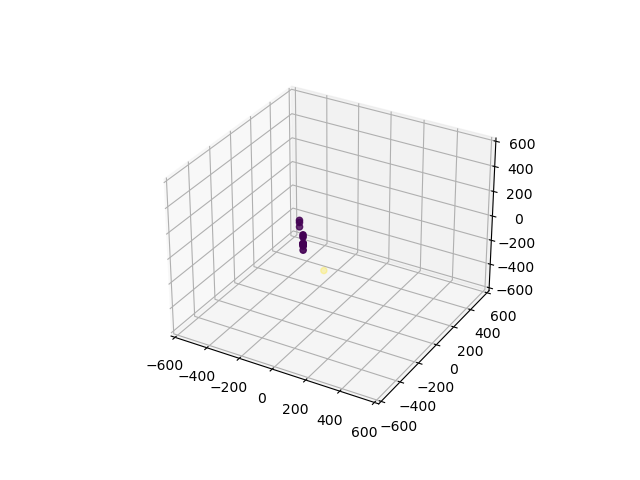

Number of clusters: 2 
 Event_id: 24


In [53]:
event_id=24
#event_id=random.choice(event_list)
event=batch1[batch1.auxiliary==False].loc[event_id]
clusters, raw_data=hcluster_euc_distance(event,150)
    
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = [a[0] for a in raw_data]
ys = [a[1] for a in raw_data]
zs = [a[2] for a in raw_data]

ax.scatter(xs, ys, zs,
           c=clusters)
scale=[-600, 600]
ax.set_xlim(scale)
ax.set_ylim(scale)
ax.set_zlim(scale)

plt.show()

print("Number of clusters:", len(set(clusters)),'\n Event_id:', event_id )

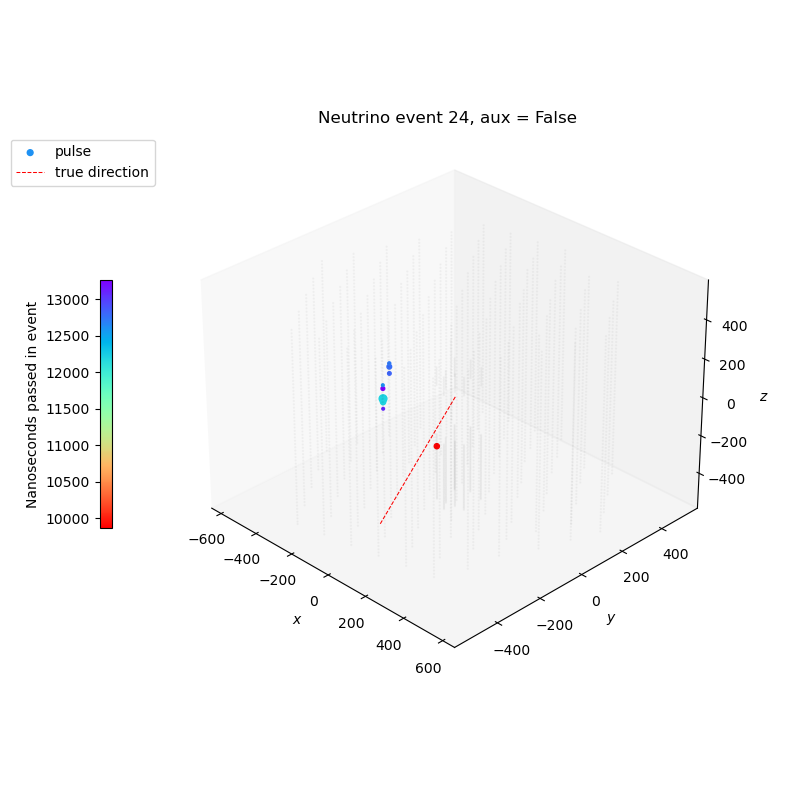

In [51]:
event_plot(event_id, aux_incl=False, show_true_direction=True)